In [1]:
from struct import *

import serial

import experiments

PROTO_END_OF_TRANSFER = b'\x0a'
PROTO_CMD_INITIALIZE = b'\x01'
PROTO_CMD_ENCRYPT = b'\x02'
PROTO_CMD_FINALIZE = b'\x03'

sm = experiments.SignalManager()

In [2]:
class Arduino:
    def __init__(self, *args, **kwargs):
        self.args = args
        self.kwargs = kwargs
        self.is_connected = False
        self.serial = None

    def connect(self):
        if not self.is_connected:
            self.serial = serial.Serial(*self.args, **self.kwargs)
            self.is_connected = True
            self.serial.read(1)
            self.serial.read(1)

    def close(self):
        if self.is_connected:
            self.is_connected = False
            self.serial.close()

    def initialize(self, plain_text, key):
        if not self.is_connected:
            raise Exception('ConnectionError')

        self.serial.write(
            pack('c16s16sc', PROTO_CMD_INITIALIZE, plain_text, key, PROTO_END_OF_TRANSFER)
        )

        return self.serial.read(1)

    def encrypt(self):
        if not self.is_connected:
            raise Exception('ConnectionError')

        self.serial.write(
            pack('cc', PROTO_CMD_ENCRYPT, PROTO_END_OF_TRANSFER)
        )

    def wait_encrypt_end(self):
        return self.serial.read(1)

    def finalize(self):
        if not self.is_connected:
            raise Exception('ConnectionError')

        self.serial.write(
            pack('cc', PROTO_CMD_FINALIZE, PROTO_END_OF_TRANSFER)
        )

        result = self.serial.read(16)
        return result

In [3]:
plain = b'abcd' * 4
key = b'\x00' * 16

aud = Arduino(port='COM3', timeout=3)

In [4]:
# aud.connect()
#
# for x in range(1):
#     aud.initialize(bytes([x] * 16), key)
#     aud.encrypt()
#     aud.wait_encrypt_end()
#     result = aud.finalize()
#     print(result)
#
# aud.close()


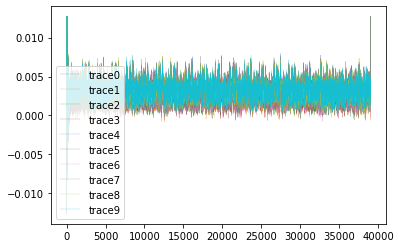

In [19]:
%matplotlib inline

import matplotlib.pyplot as plt

main_trace = []

aud.connect()

for x in range(10):
    aud.initialize(plain, bytes([1]*16))
    aud.encrypt()
    (main_volt, main_time), (trigger_volt, trigger_time) = sm.get_data(['CH1', 'CH2'])
    aud.wait_encrypt_end()
    result = aud.finalize()
    main_trace.append(main_volt[trigger_volt > 3.04])

aud.close()

for i, trace in enumerate(main_trace):
    plt.plot(trace, label=f'trace{i}')
# plt.plot(trigger_volt, label='trigger')
plt.show()

(39048,)


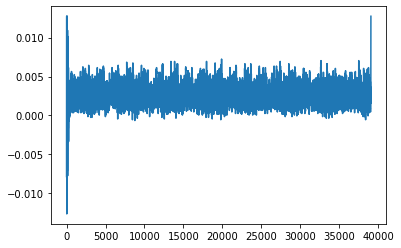

In [8]:

# sample = main_volt * (trigger_volt > 3.04)
sample = main_volt[trigger_volt > 3.04]
print(sample.shape)
plt.plot(sample)
plt.show()

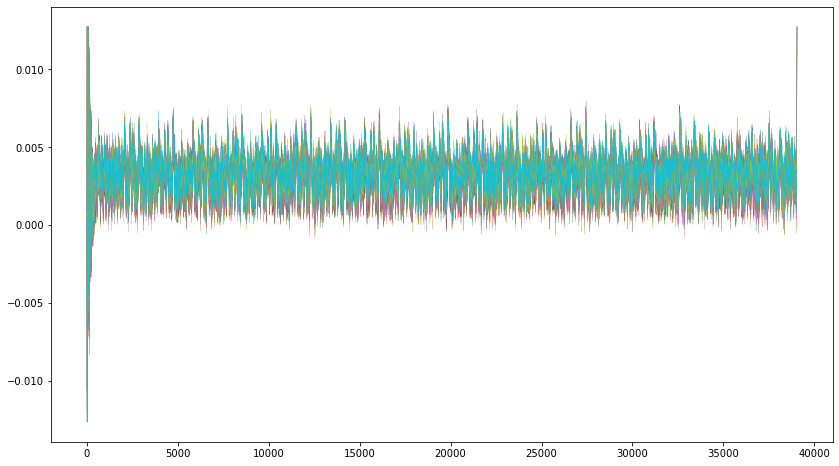

In [20]:
plt.rcParams["figure.figsize"] = (14, 8)
plt.rcParams['lines.linewidth'] = 0.2

for i, trace in enumerate(main_trace):
    plt.plot(trace, label=f'trace{i}')
plt.show()